In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import glob
import pickle
import pandas as pd
import pyccl as ccl
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import pyccl as ccl
import clmm
from scipy import stats
from clmm import Cosmology

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/')
import class_richness_mass_relation as rm_relation
import cosmology

sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/sbi')
import simulation

sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/likelihood/')
import model_completeness as comp
import model_purity as pur
import model_cluster_abundance
import model_stacked_cluster_mass

sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/pinocchio/')
import pinocchio_mass_richness_relation as sim_mr_rel
import pinocchio_binning_scheme as binning_scheme

In [2]:
def load(filename, **kwargs):
    """Loads GalaxyCluster object to filename using Pickle"""
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [3]:
log10m0, z0 = sim_mr_rel.log10m0, sim_mr_rel.z0
proxy_mu0, proxy_muz, proxy_mulog10m =  sim_mr_rel.proxy_mu0, sim_mr_rel.proxy_muz, sim_mr_rel.proxy_mulog10m
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  sim_mr_rel.proxy_sigma0, sim_mr_rel.proxy_sigmaz, sim_mr_rel.proxy_sigmalog10m
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]
which_model = 'log_normal_poisson_log_scatter'#sim_mr_rel.which_model
sigma_wl_log10mass = 0.25/np.log(10)#sim_mr_rel.sigma_wl_log10mass

In [4]:
data = load(f'/pbs/throng/lsst/users/cpayerne/capish/pinocchio/data/pinocchio_data_vector/data_vector_pinocchio_mock_{which_model}_sigma_lnMwl={sigma_wl_log10mass*np.log(10):.2f}.pkl')

In [5]:
logm_edges = binning_scheme.logm_edges
redshift_edges = binning_scheme.redshift_edges
richness_edges = binning_scheme.richness_edges
Z_bin = binning_scheme.Z_bin
LogMass_bin = binning_scheme.LogMass_bin
Richness_bin = binning_scheme.Richness_bin

# Comparison to prediction (count and mean mass)

In [6]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
#halo model
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)
halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=massdef, mass_def_strict=True)
CosmologyObject = cosmology.Cosmology(hmf=hmd, bias_model=halobias_fct)

In [7]:
RM = rm_relation.Richness_mass_relation()
RM.select(which = 'log_normal_poisson_log_scatter')

In [8]:
richness_grid = np.logspace(np.log10(20), np.log10(200), 310)
logm_grid = np.linspace(14.2, 16, 200)
z_grid = np.linspace(.2, 1, 201)

In [9]:
clc = model_cluster_abundance.ClusterAbundance(CosmologyObject = CosmologyObject, MoRObject = RM)

In [10]:
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
params = {'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmo,}
adds = {'add_purity' : False, 'add_completeness':False}
compute = {'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 
           'compute_completeness':False, 'compute_purity':False ,'compute_halo_bias':True,
          'compute_dNdzdlogMdOmega_log_slope': False}

In [11]:
count_modelling_new = clc.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)

In [12]:
integrand_count = clc.define_count_integrand(count_modelling_new, adds)

In [13]:
Omega = 0.25*(4*np.pi)
Nth = Omega * clc.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = integrand_count, grids = grids)

In [14]:
clm = model_stacked_cluster_mass.ClusterStackedMass(CosmologyObject = CosmologyObject, MoRObject = RM)

In [15]:
Nlog10Mth = Omega * clm.Cluster_dNd0mega_Mass_ProxyZ(bins, integrand_count = integrand_count, grids = grids, Nlog10m = True)
log10Mth = Nlog10Mth/Nth

In [16]:


stacked_simulator_pl = simulation.Universe_simulation('stacked_counts',
                                                        variable_params=['omega_m', 
                                                                         'sigma_8', 
                                                                         'h',
                                                                         'alpha' , 
                                                                         'c' , 
                                                                         'beta',
                                                                         'sigma' ],
                                                        fixed_params={'w_0': -1, 'w_a': 0 } )
stacked_simulator_pl.selection_richness = 0
def dOmega_z(z): return 0.25 * 4 * np.pi
stacked_simulator_pl.dOmega = dOmega_z
stacked_simulator_pl.richness_bins = richness_edges
stacked_simulator_pl.redshift_bins = redshift_edges
stacked_simulator_pl.sigma_mwl = 0
stacked_simulator_pl.include_mwl_measurement_errors = False
stacked_simulator_pl.correlation_mass_evolution = False
stacked_simulator_pl.set_richness_mass_relation( 'constantins model' )
stacked_simulator_pl.set_bins( z_bins = np.arange( 0.2 , 1 , 0.001 ) , 
                               log10m_bins=  np.arange( 14.2 , 16 , 0.001))
stacked_simulator_pl.massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
stacked_simulator_pl.halobias_fct = halobias_fct
stacked_simulator_pl.hmd = hmd
stacked_simulator_pl.add_SSC = False
stacked_simulator_pl.use_hybrid = True
stacked_simulator_pl.Z_edges_hybrid = binning_scheme.redshift_edges
Z_bin_hybrid = [[stacked_simulator_pl.Z_edges_hybrid[i], stacked_simulator_pl.Z_edges_hybrid[i+1]] for i in range(len(stacked_simulator_pl.Z_edges_hybrid)-1)]


In [17]:
sim_n_clusters = np.zeros([len( Richness_bin)  ,len( Z_bin)])
sim_mwl_mean = np.zeros([len( Richness_bin)  ,len( Z_bin)])
n_sim = 10
for n in range(n_sim):
    np.random.seed(n)
    sim_obs_ = stacked_simulator_pl.run_simulation([ 0.30711 , 0.8288 , 0.6777 , 2.2 , 3.2, 0 , 0.5 ])
    sim_n_clusters += sim_obs_[:25].reshape( len( Richness_bin)  ,len( Z_bin)   )
    sim_mwl_mean += sim_obs_[25:].reshape( len( Richness_bin), len( Z_bin) )
sim_n_clusters = sim_n_clusters/n_sim
sim_mwl_mean = sim_mwl_mean/n_sim

0.30711 0.048254 0.6777 0.8288
0.30711 0.048254 0.6777 0.8288
0.30711 0.048254 0.6777 0.8288
0.30711 0.048254 0.6777 0.8288
0.30711 0.048254 0.6777 0.8288
0.30711 0.048254 0.6777 0.8288
0.30711 0.048254 0.6777 0.8288
0.30711 0.048254 0.6777 0.8288
0.30711 0.048254 0.6777 0.8288
0.30711 0.048254 0.6777 0.8288


In [18]:
#fig, ax = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'height_ratios': [2,1]})
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=None)
#for i in range(5):
#    ax[0,0].errorbar(np.mean(Richness_bin, axis=1), Nth[:,i], label = 'z = '+f'{np.mean(Z_bin[i]):.2f}', color = f'C{i}')
#    ax[0,0].errorbar(np.mean(Richness_bin, axis=1), sim_n_clusters[:,i], color = f'C{i}')
#    ax[0,0].errorbar(np.mean(Richness_bin, axis=1),  data['mean_count_richness_redshift'][:,i], data['err_mean_count_richness_redshift'][:,i], fmt= '--', color = f'C{i}')
#    ax[1,0].plot(np.mean(Richness_bin, axis=1), 100*(Nth[:,i] - data['mean_count_richness_redshift'][:,i])/Nth[:,i],  color = f'C{i}')
#    ax[1,0].plot(np.mean(Richness_bin, axis=1), 100*(sim_n_clusters[:,i] - data['mean_count_richness_redshift'][:,i])/Nth[:,i], '--',  color = f'C{i}')
    

#for i in range(5):
#    ax[0,1].errorbar(np.mean(Richness_bin, axis=1), log10Mth[:,i], label = 'z = '+f'{np.mean(Z_bin[i]):.2f}', color = f'C{i}')
#    ax[0,1].errorbar(np.mean(Richness_bin, axis=1), sim_mwl_mean[:,i], label = 'z = '+f'{np.mean(Z_bin[i]):.2f}', color = f'C{i}')
#    ax[0,1].errorbar(np.mean(Richness_bin, axis=1),  data['mean_log10mass_richness_redshift'][:,i], data['err_mean_log10mass_richness_redshift'][:,i], fmt='--', color = f'C{i}')
#    ax[1,1].errorbar(np.mean(Richness_bin, axis=1), 100*(log10Mth[:,i] - data['mean_log10mass_richness_redshift'][:,i])/log10Mth[:,i], label = 'z = '+f'{np.mean(Z_bin[i]):.2f}', color = f'C{i}')
#    ax[1,1].errorbar(np.mean(Richness_bin, axis=1), 100*(sim_mwl_mean[:,i] - data['mean_log10mass_richness_redshift'][:,i])/log10Mth[:,i], fmt='--', color = f'C{i}')
#    for i in range(2):
#        ax[1,i].set_ylabel('bias (%)', fontsize=20,)
#        ax[0,0].set_ylabel('cluster count', fontsize=20,)
#        ax[0,1].set_ylabel(r'$\langle \log_{10} M\rangle$', fontsize=20,)
#        ax[1,i].set_xlabel('richness', fontsize=20,)
#        for j in range(2):
#            ax[i,j].grid(which='both')
#            ax[0,0].legend()
#            ax[i,j].tick_params(axis='both', which = 'major', labelsize= 13)

#plt.tick_params(axis='both', which = 'major', labelsize= 13)

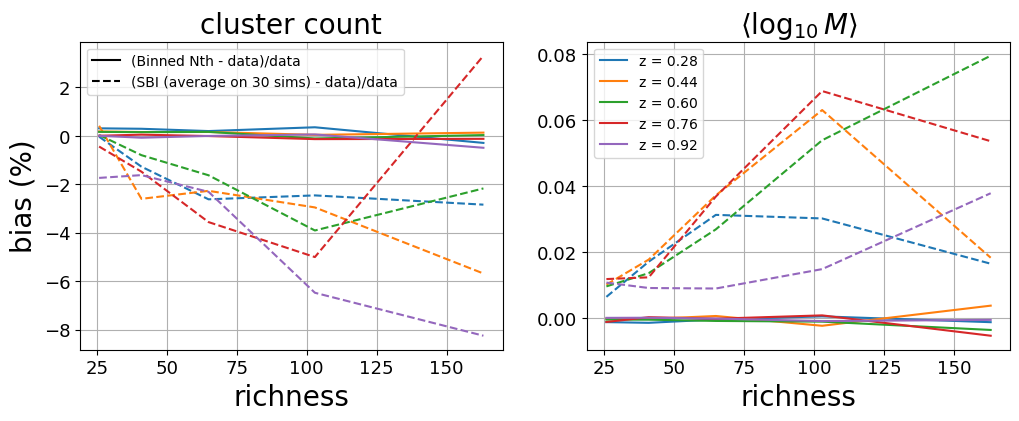

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), )
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=None)
for i in range(5):
    ax[0].plot(np.mean(Richness_bin, axis=1), 100*(Nth[:,i] - data['mean_count_richness_redshift'][:,i])/data['mean_count_richness_redshift'][:,i],  color = f'C{i}')
    ax[0].plot(np.mean(Richness_bin, axis=1), 100*(sim_n_clusters[:,i] - data['mean_count_richness_redshift'][:,i])/data['mean_count_richness_redshift'][:,i], '--',  color = f'C{i}')

ax[0].plot([], [], '-k', label = '(Binned Nth - data)/data')
ax[0].plot([], [], '--k', label = '(SBI (average on 30 sims) - data)/data')

for i in range(5):
    ax[1].errorbar(np.mean(Richness_bin, axis=1), 100*(log10Mth[:,i] - data['mean_log10mass_richness_redshift'][:,i])/data['mean_log10mass_richness_redshift'][:,i], label = 'z = '+f'{np.mean(Z_bin[i]):.2f}', color = f'C{i}')
    ax[1].errorbar(np.mean(Richness_bin, axis=1), 100*(sim_mwl_mean[:,i] - data['mean_log10mass_richness_redshift'][:,i])/data['mean_log10mass_richness_redshift'][:,i], fmt='--', color = f'C{i}')
for i in range(2):
    ax[0].set_ylabel('bias (%)', fontsize=20,)
    ax[0].set_title('cluster count', fontsize=20,)
    ax[1].set_title(r'$\langle \log_{10} M\rangle$', fontsize=20,)
    ax[i].set_xlabel('richness', fontsize=20,)
for j in range(2):
    ax[j].grid()
    ax[j].legend()
    ax[j].tick_params(axis='both', which = 'major', labelsize= 13)

#plt.tick_params(axis='both', which = 'major', labelsize= 13)